In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import os
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
from torchvision.datasets import MNIST
from torchvision import transforms

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!tar xvzf "/content/drive/MyDrive/CUB_200_2011.tgz"

In [ ]:
with open('/content/CUB_200_2011/images.txt') as file:
    images_path = [line.rstrip().split(" ")[1] for line in file]

In [ ]:
images_path

In [ ]:

with open('/content/CUB_200_2011/train_test_split.txt') as file:
    train_id=[]
    test_id=[]
    train_test=[]
    for line in file:
      if(int(line.rstrip().split(" ")[1])==1):
        train_id.append(images_path[int(line.rstrip().split(" ")[0])-1])
      else:
        test_id.append(images_path[int(line.rstrip().split(" ")[0])-1])
      train_test.append(int(line.rstrip().split(" ")[1]))


In [ ]:
test_id[0]

'001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg'

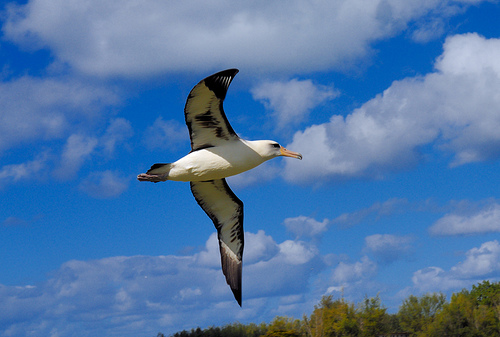

In [ ]:
from PIL import Image
import cv2 #EDIT, this line added

im = Image.open('/content/CUB_200_2011/images/'+train_id[54])
im.show('image',im)

In [ ]:
with open('/content/CUB_200_2011/image_class_labels.txt') as file:
    train_label=[]
    test_label=[]
    for line in file:
      if(train_test[int(line.rstrip().split(" ")[0])-1]==1):
        train_label.append(int(line.rstrip().split(" ")[1])-1)
      else:
        test_label.append(int(line.rstrip().split(" ")[1])-1)

In [ ]:
from numpy import asarray

In [ ]:
def make_sample(n_way,n_support,n_query,x,y):
  sample=[]
  x=np.array(x)
  y=np.array(y)
  k=np.random.choice(np.unique(y), n_way, replace=True)
  frac=0.75
  newsize=(64,64)

  for label in k:
    data=x[y==label]
    perm = np.random.permutation(data)
    sample_cls = perm[:(n_support+n_query)]
    sample.append(sample_cls)

  # images = [[None for j in range(n_support+n_query)] for i in range(n_way)]
  images = np.zeros([n_way,n_support+n_query,newsize[0],newsize[1],3])
  for i in range(n_way):
    c=0
    for path in sample[i]:
        with Image.open('/content/CUB_200_2011/images/'+path) as img:
            left = img.size[0]*((1-frac)/2)
            upper = img.size[1]*((1-frac)/2)
            right = img.size[0]-((1-frac)/2)*img.size[0]
            bottom = img.size[1]-((1-frac)/2)*img.size[1]
            img=img.crop((left, upper, right, bottom))
            img = img.resize(newsize)
            img = img.convert("RGB")
            images[i][c]=asarray(img)

        c+=1;


  images = np.array(images)
  images=torch.from_numpy(images).float()
  images = images.permute(0,1,4,2,3)
  return ({
      'images': images,
      'n_way': n_way,
      'n_support': n_support,
      'n_query': n_query
      })

In [ ]:

sample_example = make_sample(4, 3,3, train_id, train_label)
print(sample_example['images'][0][0])

tensor([[[ 93.,  93.,  94.,  ..., 104., 103., 103.],
         [ 93.,  94.,  94.,  ..., 105., 104., 103.],
         [ 94.,  94.,  95.,  ..., 105., 104., 104.],
         ...,
         [100., 100., 101.,  ..., 106., 105., 105.],
         [101., 100., 100.,  ..., 106., 106., 105.],
         [100.,  99., 100.,  ..., 106., 106., 106.]],

        [[147., 147., 145.,  ..., 160., 158., 158.],
         [148., 147., 146.,  ..., 160., 159., 158.],
         [148., 148., 147.,  ..., 160., 158., 158.],
         ...,
         [157., 158., 158.,  ..., 162., 161., 161.],
         [158., 157., 158.,  ..., 162., 162., 162.],
         [158., 158., 159.,  ..., 162., 162., 162.]],

        [[ 55.,  56.,  57.,  ...,  72.,  72.,  72.],
         [ 58.,  57.,  57.,  ...,  74.,  72.,  71.],
         [ 58.,  57.,  56.,  ...,  74.,  72.,  73.],
         ...,
         [ 57.,  56.,  56.,  ...,  54.,  57.,  55.],
         [ 56.,  56.,  55.,  ...,  57.,  57.,  56.],
         [ 56.,  55.,  53.,  ...,  56.,  57.,  56.]]]

In [ ]:
def display_sample(sample):
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  grid = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1])

  grid_norm = (grid - torch.min(grid)) / (torch.max(grid) - torch.min(grid))
  grid_np = grid_norm.numpy()
  plt.imshow(grid_np.transpose((1, 2, 0)))
  plt.axis('off')
  plt.show()
  # plt.figure(figsize = (16,7))
  # plt.imshow(out.permute(1, 2, 0))

torch.Size([3, 6, 3, 64, 64])


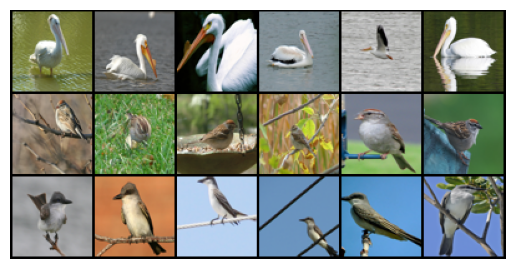

In [ ]:
sample_example = make_sample(3, 2,4, train_id, train_label)
print(sample_example['images'].shape)
display_sample(sample_example['images'])

In [ ]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.size(0), -1)

def load_protonet_conv(**kwargs):
  """
  Loads the prototypical network model
  Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
  Returns:
      Model (Class ProtoNet)
  """
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )

  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, hid_dim),
    conv_block(hid_dim, z_dim),
    Flatten()
    )

  return ProtoNet(encoder)

In [ ]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
        encoder : CNN encoding the images in sample
        n_way (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    # self.encoder = encoder.cuda()
    self.encoder = encoder

  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_way, n_support+n_query, (dim))
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    # sample_images = sample['images'].cuda()
    sample_images = sample['images']
    n_way = sample['n_way']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]
    x_query = sample_images[:, n_support:]

    #target indices are 0 ... n_way-1
    target_inds = torch.arange(0, n_way).view(n_way, 1, 1).expand(n_way, n_query, 1).long()
    target_inds = Variable(target_inds, requires_grad=False)
    # target_inds = target_inds.cuda()
    target_inds = target_inds

    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_way * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_way * n_query, *x_query.size()[2:])], 0)

    z = self.encoder.forward(x)
    z_dim = z.size(-1) #usually 64
    z_proto = z[:n_way*n_support].view(n_way, n_support, z_dim).mean(1)
    z_query = z[n_way*n_support:]

    #compute distances
    dists = euclidean_dist(z_query, z_proto)

    #compute probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_way, n_query, -1)

    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()

    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }


In [ ]:
def euclidean_dist(x, y):

  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

In [ ]:
from tqdm import tqdm_notebook
from tqdm import tnrange

In [ ]:
def train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  #divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.7, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      sample = make_sample(n_way, n_support, n_query, train_x, train_y)
      optimizer.zero_grad()
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    epoch += 1
    scheduler.step()

In [ ]:
%%time

model = load_protonet_conv(
    x_dim=(3,64,64),
    hid_dim=64,
    z_dim=64,
    )

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_way = 20
n_support = 5
n_query = 5

train_x = train_id
train_y = train_label

max_epoch = 20
epoch_size = 200

train(model, optimizer, train_x, train_y, n_way, n_support, n_query, max_epoch, epoch_size)

<ipython-input-32-1a6b28680536>:24: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):


Epoch 1 train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 -- Loss: 6.7431 Acc: 0.1955


Epoch 2 train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2 -- Loss: 2.2907 Acc: 0.2834


Epoch 3 train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3 -- Loss: 2.1333 Acc: 0.3237


Epoch 4 train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4 -- Loss: 2.0517 Acc: 0.3491


Epoch 5 train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5 -- Loss: 1.9522 Acc: 0.3718


Epoch 6 train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6 -- Loss: 1.8839 Acc: 0.3942


Epoch 7 train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7 -- Loss: 1.8118 Acc: 0.4142


Epoch 8 train:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8 -- Loss: 1.7730 Acc: 0.4269


Epoch 9 train:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
print(torch.cuda.device_count())   # --> 0
print(torch.cuda.is_available())   # --> False
print(torch.version.cuda)

In [ ]:
def test(model, test_x, test_y, n_way, n_support, n_query, test_episode):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_way (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  running_loss = 0.0
  running_acc = 0.0
  for episode in tnrange(test_episode):
    sample = make_sample(n_way, n_support, n_query, test_x, test_y)
    loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [ ]:
n_way = 20
n_support = 6
n_query = 6

test_x = test_id
test_y = test_label

test_episode = 1000

test(model, test_x, test_y, n_way, n_support, n_query, test_episode)

In [ ]:
my_sample = make_sample(n_way, n_support, n_query, test_x, test_y)
display_sample(my_sample['images'])

In [ ]:
my_loss, my_output = model.set_forward_loss(my_sample)

In [ ]:
my_output

In [ ]:
class MatchingNetworks(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MatchingNetworks, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_size, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, hidden_size, 3, padding=1),
            nn.BatchNorm2d(hidden_size),
            nn.ReLU(inplace=True),
        )
        self.embedding_size = hidden_size
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1, bias=False),
            nn.Softmax(dim=1),
        )
        self.classifier = nn.Linear(hidden_size, output_size)

    def forward(self, support_set, query_set):
        batch_size, num_support, channels, height, width = support_set.size()
        num_query = query_set.size(1)

        # Embed support set and reshape
        support_set = support_set.view(-1, channels, height, width)
        embedded_support_set = self.encoder(support_set)
        embedded_support_set = embedded_support_set.view(batch_size, num_support, self.embedding_size, -1)

        # Embed query set and reshape
        query_set = query_set.view(-1, channels, height, width)
        embedded_query_set = self.encoder(query_set)
        embedded_query_set = embedded_query_set.view(batch_size * num_query, self.embedding_size, -1)

        # Compute attention weights
        support_set_norm = embedded_support_set.norm(dim=2, keepdim=True)
        embedded_support_set_norm = embedded_support_set / support_set_norm
        query_set_norm = embedded_query_set.norm(dim=1, keepdim=True)
        embedded_query_set_norm = embedded_query_set / query_set_norm
        attention_scores = torch.bmm(embedded_query_set_norm.unsqueeze(1), embedded_support_set_norm.transpose(2, 3))
        attention_weights = self.attention(attention_scores)

        # Weighted sum of support set embeddings
        support_set = support_set.view(-1, channels, height, width)
        weighted_support_set = (attention_weights.unsqueeze(2) * support_set.view(batch_size * num_support, channels, height, width)).sum(dim=1)
        weighted_support_set = weighted_support_set.view(batch_size, num_support, -1)

        # Compute prototype of each class
        prototypes = weighted_support_set.mean(dim=1)

        # Predict class of query set
        query_scores = self.classifier(embedded_query_set)
        query_scores = query_scores.view(batch_size, num_query, -1)
        query_scores = (query_scores * prototypes.unsqueeze(1)).sum(dim=2)

        return query_scores